In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

/Users/mturilli/Virtualenvs/RP-PAPER-IPDPS18/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
ssc_sessions = pd.read_csv('data/synapse/strong_scaling/sessions.csv', index_col=0)
ssc_pilots = pd.read_csv('data/synapse/strong_scaling/pilots.csv', index_col=0)
ssc_units = pd.read_csv('data/synapse/strong_scaling/units.csv', index_col=0)

In [3]:
print 'Synapse Strong Scaling: Total number of successful runs: %s' % ssc_sessions.shape[0]
print 'Synapse Strong Scaling: Total number of pilots: %s' % ssc_pilots.shape[0]
print 'Synapse Strong Scaling: Total number of units: %s\n' % ssc_units.shape[0]

Synapse Strong Scaling: Total number of successful runs: 4
Synapse Strong Scaling: Total number of pilots: 4
Synapse Strong Scaling: Total number of units: 65536



# Synapse

## Strong Scaling (exp1)

Definitions: 
* Strong scalability: how the solution time varies with the number of processors for a fixed total problem size
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 16384   | 32          | 32            | 1       | 16384        | 480m (8h)      | 12h      | 12h          | Titan    |
| 2    | 16384   | 32          | 16            | 1       | 32768        | 240m (4h)      | 6h       | 12h          | Titan    |
| 2    | 16384   | 32          | 8             | 1       | 65536        | 120m (2h)      | 3h       | 24h          | Titan    |
| 2    | 16384   | 32          | 4             | 1       | 131072       | 60m  (1h)      | 2h       | 24h          | Titan    |
| 2    | 16384   | 32          | 2             | 1       | 262144       | 30m  (0.5h)    | 2h       | 24h          | Titan    |

In [4]:
ssc = ssc_sessions[ssc_sessions.experiment == 'exp1'][
    ['ncore','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['ncore']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

ssc.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
ssc.rename(index={i: '%s/%s' % (ssc_sessions[ssc_sessions.ncore == i].nunit[0], i) for i in ssc.index.get_values()}, 
           inplace=True)
ssc

TTQ                Agent queueing            Agent queueing execution                     TTX                       TTC                Agent scheduling            
                     mean            std           mean        std                     mean        std         mean         std          mean            std             mean         std
ncore                                                                                                                                                                                    
16384/32816  117918.90005   52845.711064       480.8133   3.718533               184.740061  89.250795  14358.29425  258.935079  132400.46195   52624.290475     13405.488704  238.037170
16384/65584  346639.07670  472754.901373      1030.9101  14.207755               121.923205   3.088517   7611.91810   29.168296  354369.67560  472793.501342      6632.908649    8.731992

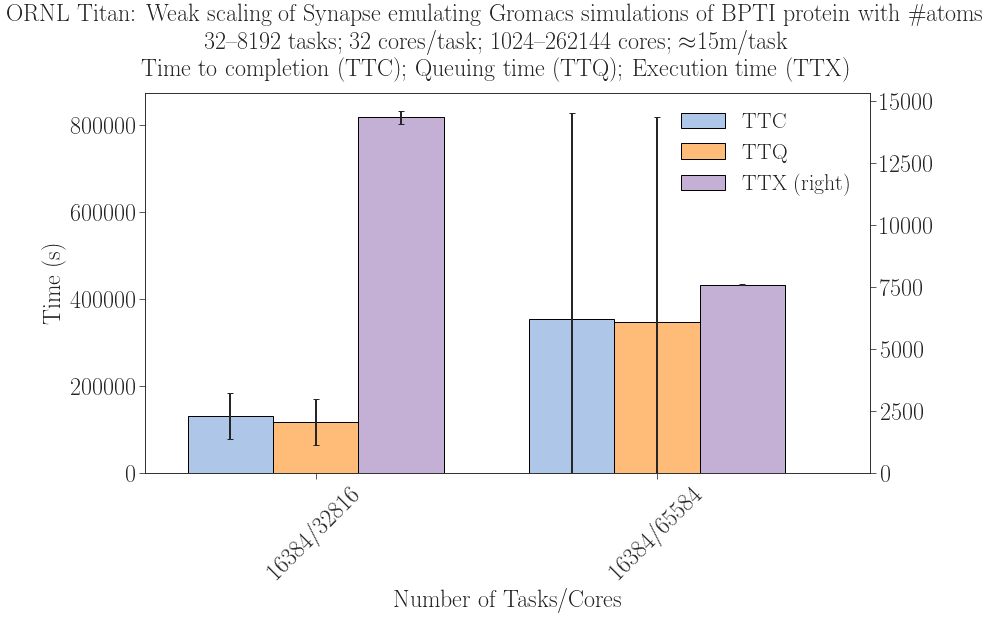

In [5]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Time to completion (TTC); Queuing time (TTQ); Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
ssc['TTC'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
    label='TTC')

ssc['TTQ'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std',
    position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
    label='TTQ')

ssc['TTX'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std', 
    position=-0.5, width=0.25, color=tableau20[9], ax=ax, rot=45, secondary_y=True,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_rp_synapse_strong_scaling.pdf', dpi=600, bbox_inches='tight')

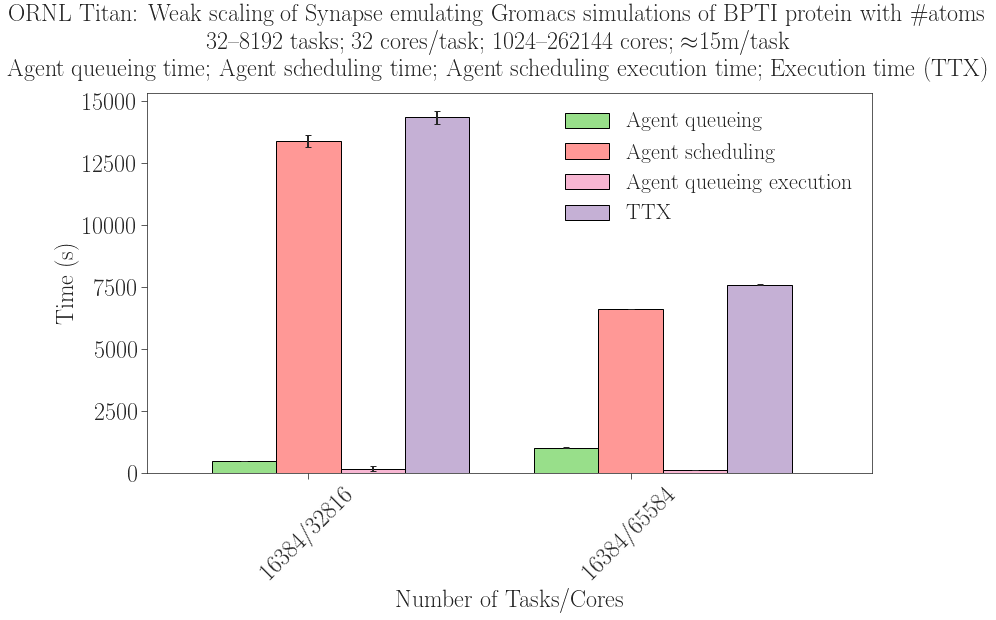

In [6]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Agent queueing time; Agent scheduling time; Agent scheduling execution time; Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
ssc['Agent queueing'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std',
    position=1.5, width=0.20, color=tableau20[5], ax=ax, rot=45,
    label='Agent queueing')

ssc['Agent scheduling'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std',
    position=0.5, width=0.20, color=tableau20[7], ax=ax, rot=45,
    label='Agent scheduling')

ssc['Agent queueing execution'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std',
    position=-0.5, width=0.20, color=tableau20[13], ax=ax, rot=45,
    label='Agent queueing execution')

ssc['TTX'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std', 
    position=-1.5, width=0.20, color=tableau20[9], ax=ax, rot=45,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_agent_synapse_strong_scaling.pdf', dpi=600, bbox_inches='tight')

# Analysis: Why we scale at 16384/32816 and 16384/65584 tasks/cores

In [7]:
# Load sessions for Synapse experiment 1
ssc_sras = load_sessions_cores('/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/synapse/strong_scaling', 
                         ssc_sessions, 
                         sorted(ssc_sessions.ncore.unique().tolist()))

## 16384/32816 tasks/cores $-$ Run 1

In [8]:
# Common variables across plotting 
sessions = ssc_sessions
units    = ssc_units
session  = ssc_sras[32816][0]
sid      = session._sid
snunit   = ssc_sessions.loc[sid].nunit
sncore   = ssc_sessions.loc[sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Strong Scaling'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid, snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

Text(0,0.5,u'Number of Units')

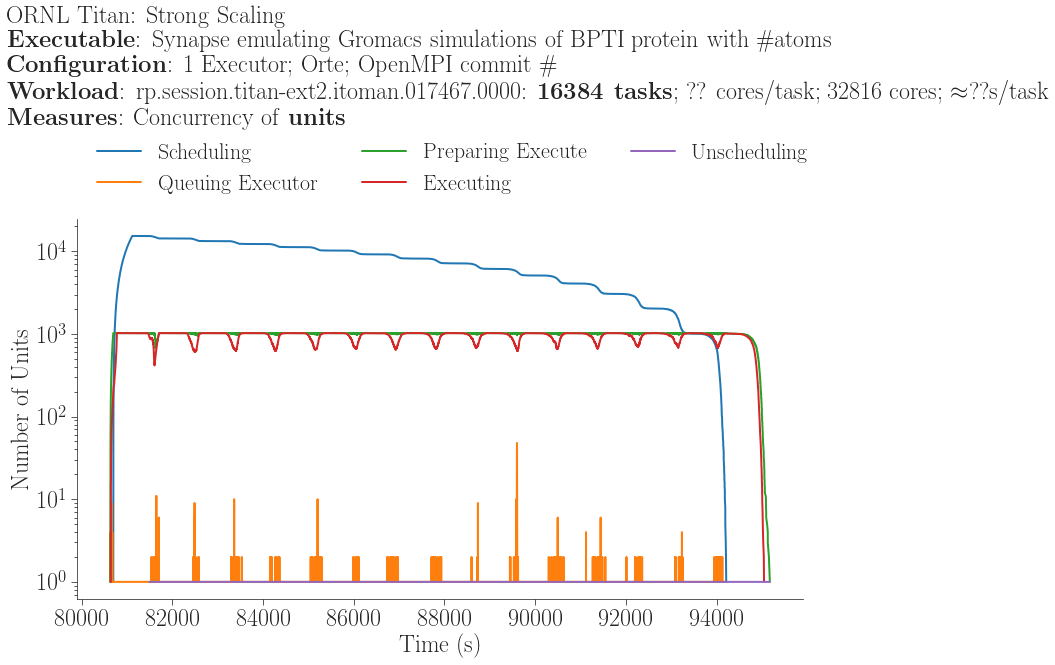

In [9]:
fig, ax  = fig_setup()

title_desc = '\\textbf{Measures}: Concurrency of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

plt.yscale('log', basex=2)
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

Text(0,0.5,u'Time (s)')

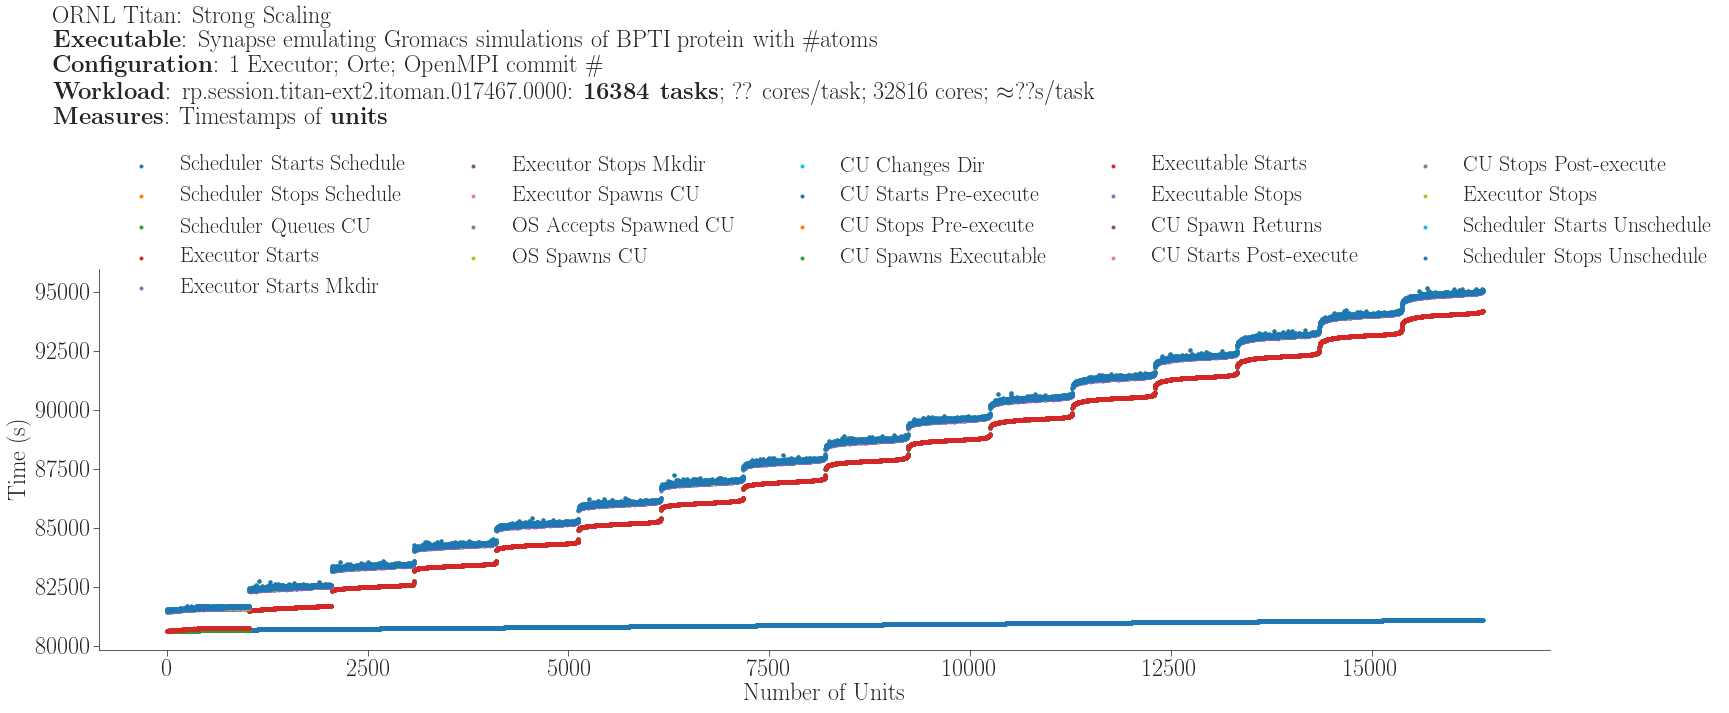

In [10]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.4, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-execute'].index      , df['CU Stops Post-execute']      , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')

Text(0,0.5,u'Time (s)')

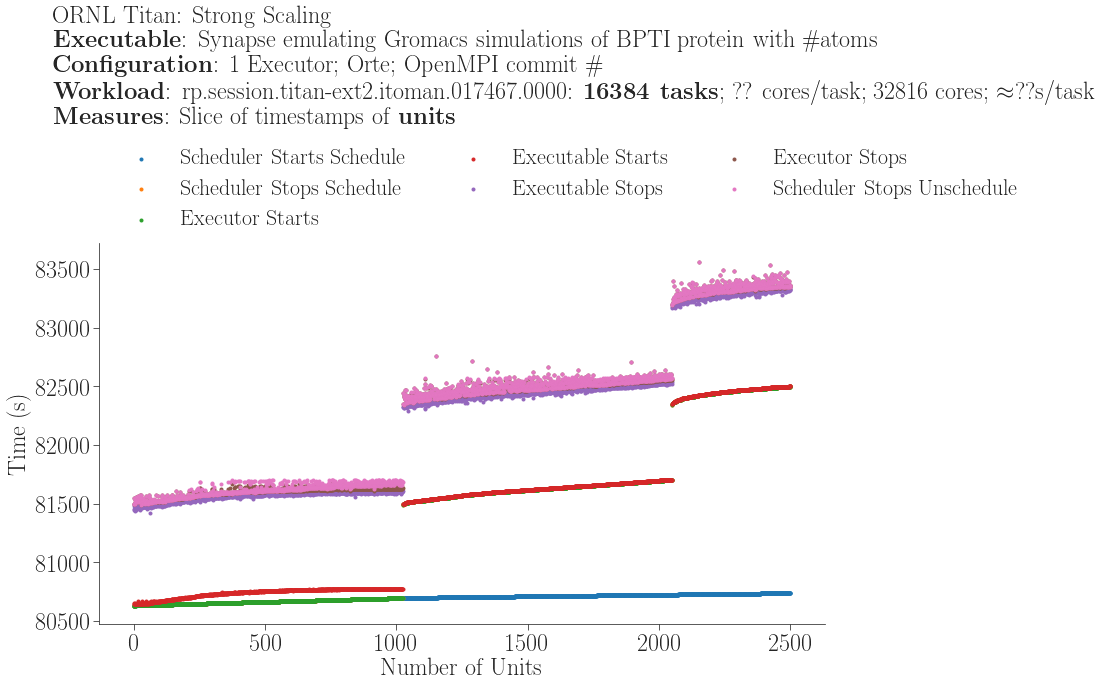

In [11]:
fig, ax = fig_setup()

title_desc = '\\textbf{Measures}: Slice of timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.075, y=1.35, horizontalalignment='left')

# df = get_df_unit_events(session)
df = df.iloc[0:2501]

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
# plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
# plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
# plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
# plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
# plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
# plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
# plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
# plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
# plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
# plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
# plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
# plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
# plt.scatter(df['CU Stops Post-executed'].index     , df['CU Stops Post-executed']     , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
# plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.3))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

## 16384/32816 tasks/cores $-$ Run 2

In [12]:
# Common variables across plotting 
sessions = ssc_sessions
units    = ssc_units
session  = ssc_sras[32816][1]
sid      = session._sid
snunit   = ssc_sessions.loc[sid].nunit
sncore   = ssc_sessions.loc[sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Strong Scaling'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid, snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

Text(0,0.5,u'Number of Units')

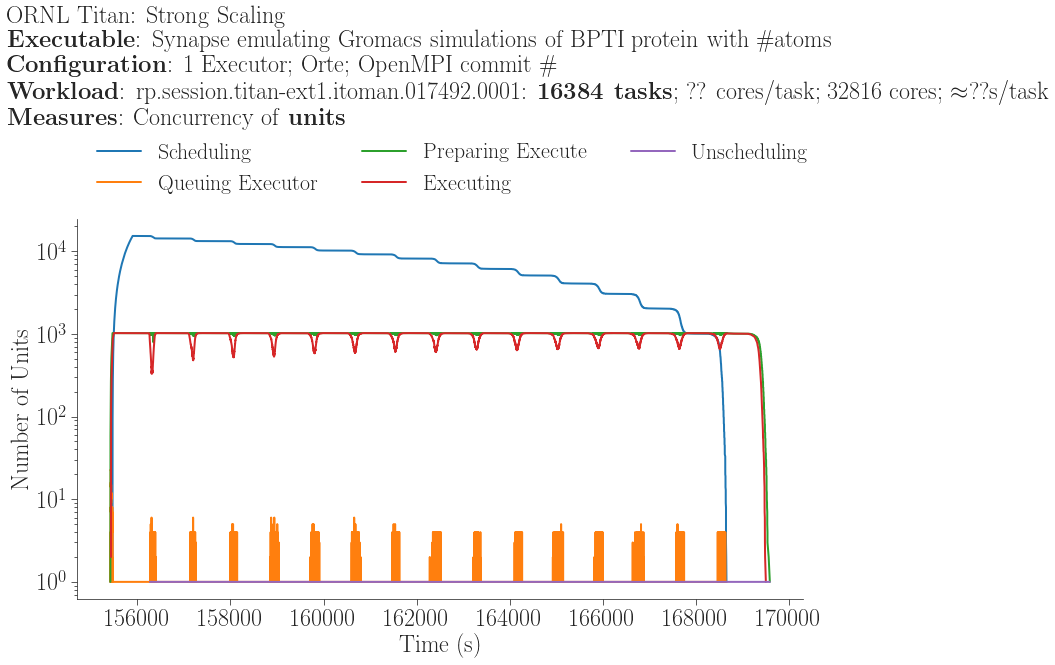

In [13]:
fig, ax  = fig_setup()

title_desc = '\\textbf{Measures}: Concurrency of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

plt.yscale('log', basex=2)
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

Text(0,0.5,u'Time (s)')

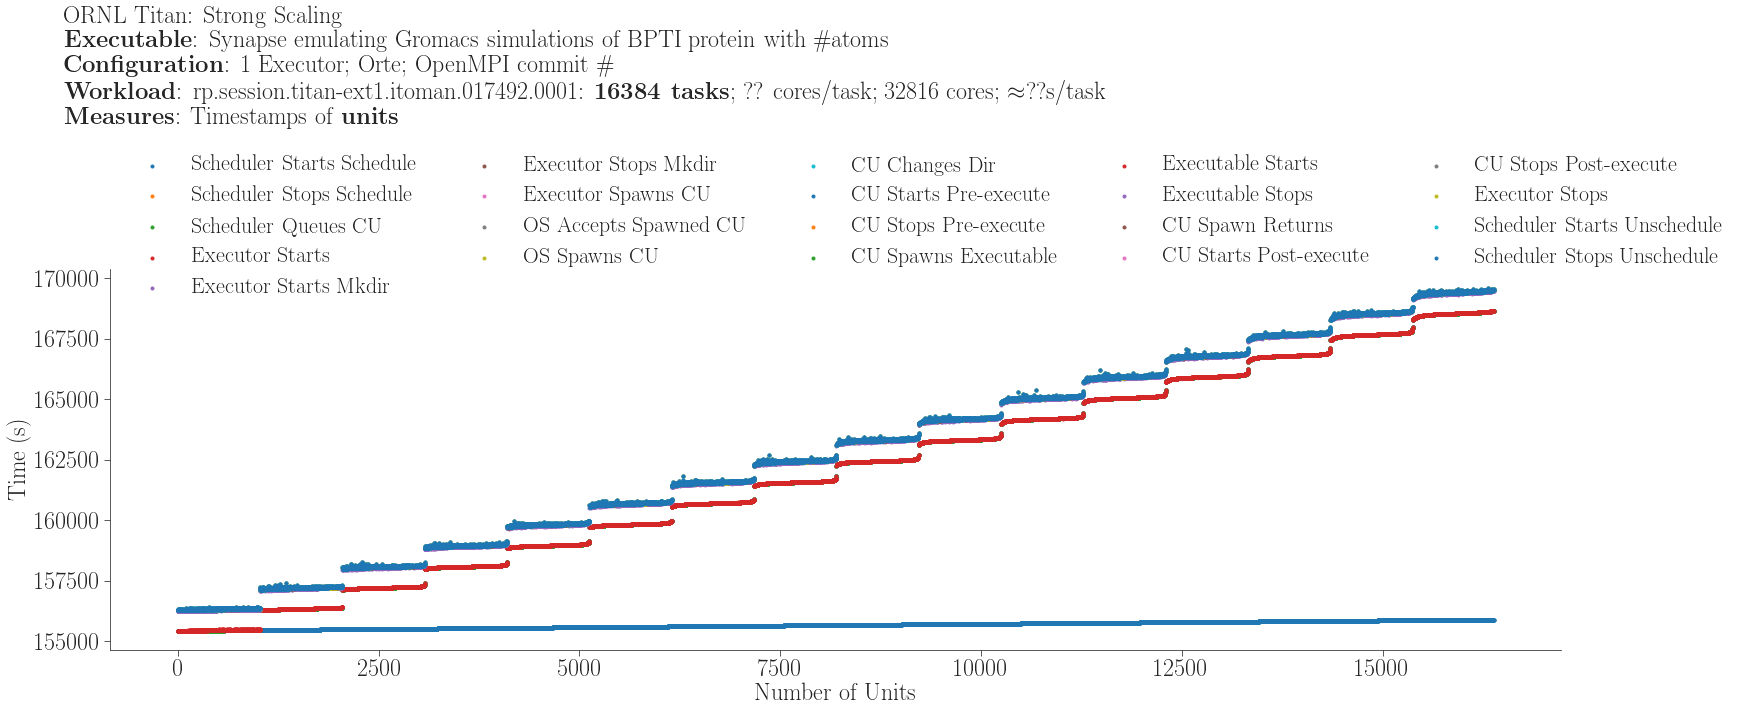

In [14]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.4, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-execute'].index      , df['CU Stops Post-execute']      , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')

## 16384/65584 tasks/cores $-$ Run 2

In [15]:
# Common variables across plotting 
sessions = ssc_sessions
units    = ssc_units
session  = ssc_sras[65584][1]
sid      = session._sid
snunit   = ssc_sessions.loc[sid].nunit
sncore   = ssc_sessions.loc[sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Strong Scaling'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid, snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

Text(0,0.5,u'Number of Units')

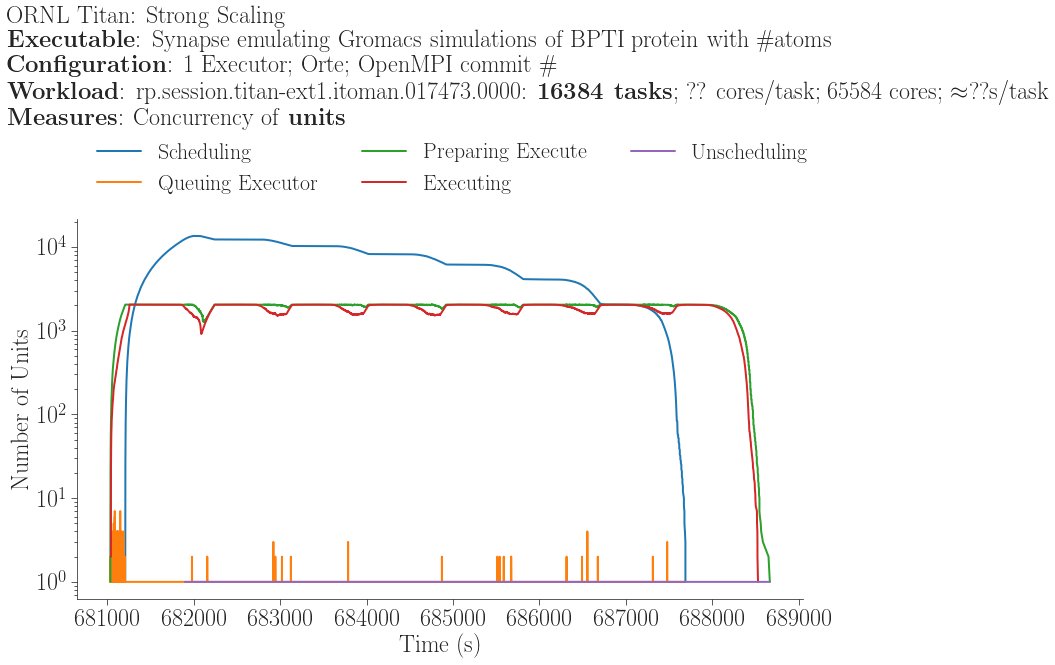

In [16]:
fig, ax  = fig_setup()

title_desc = '\\textbf{Measures}: Concurrency of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

plt.yscale('log', basex=2)
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

Text(0,0.5,u'Time (s)')

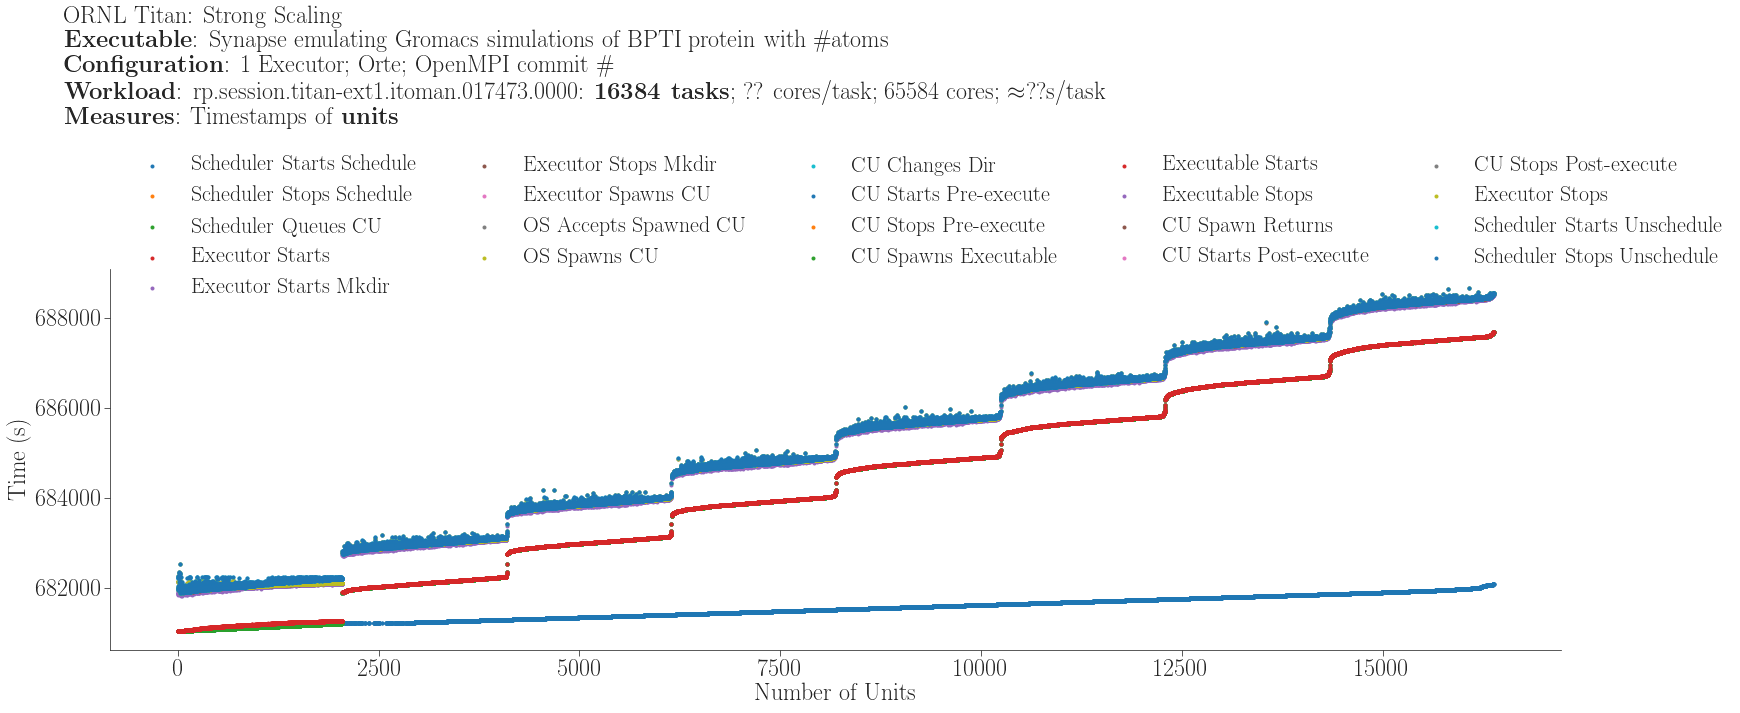

In [17]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.4, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-execute'].index      , df['CU Stops Post-execute']      , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')

## 16384/65584 tasks/cores $-$ Run 1

In [18]:
# Common variables across plotting 
sessions = ssc_sessions
units    = ssc_units
session  = ssc_sras[65584][0]
sid      = session._sid
snunit   = ssc_sessions.loc[sid].nunit
sncore   = ssc_sessions.loc[sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Strong Scaling'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid, snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

Text(0,0.5,u'Number of Units')

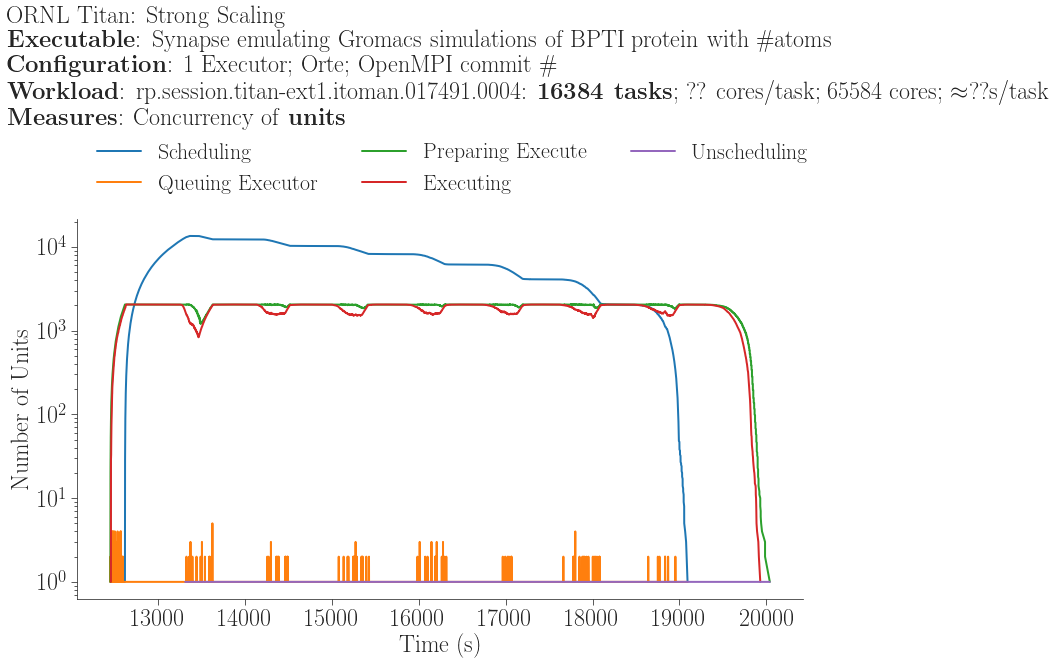

In [19]:
fig, ax  = fig_setup()

title_desc = '\\textbf{Measures}: Concurrency of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

plt.yscale('log', basex=2)
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

Text(0,0.5,u'Time (s)')

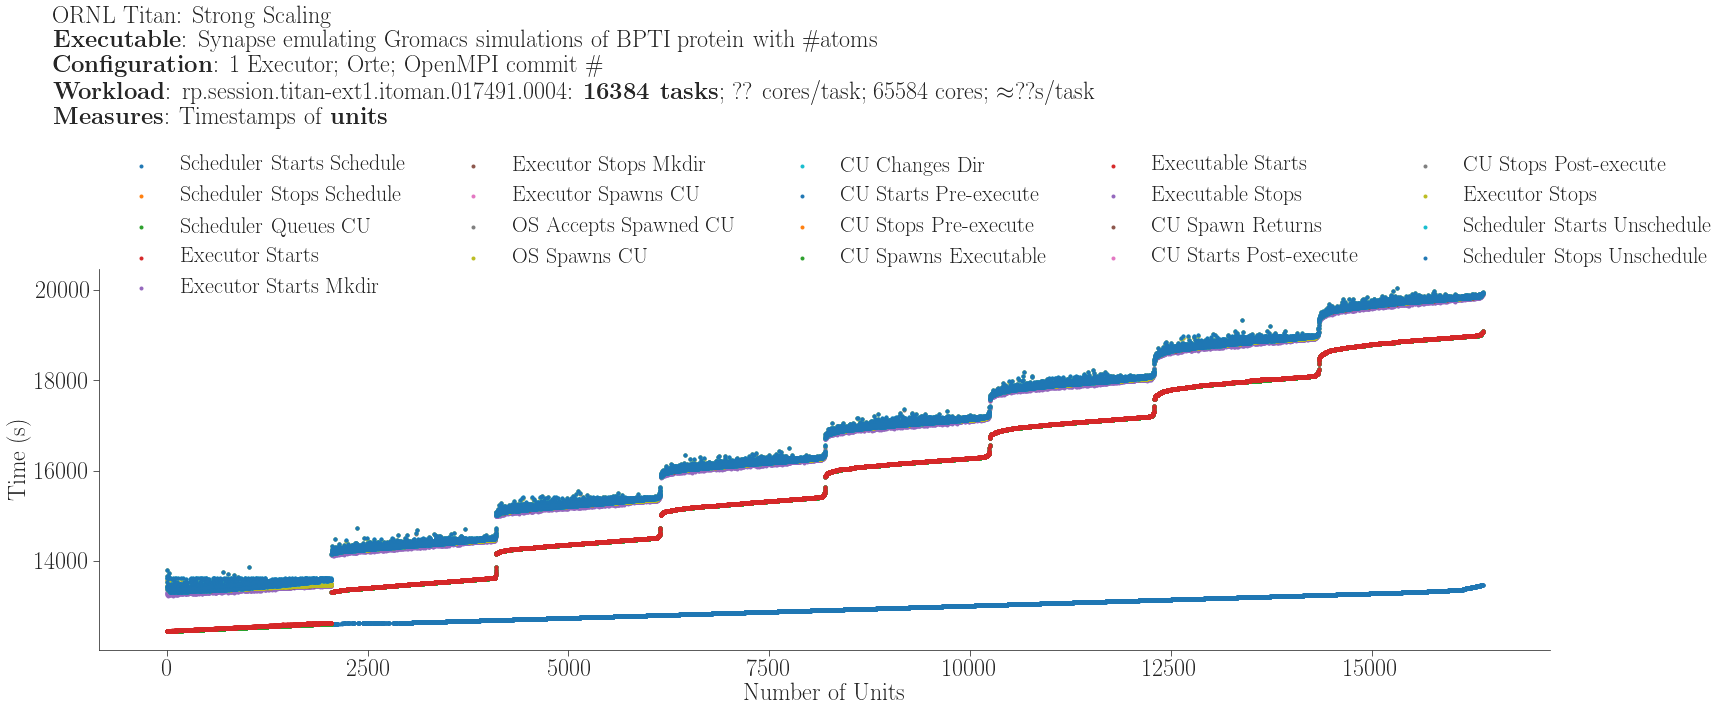

In [20]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.4, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-execute'].index      , df['CU Stops Post-execute']      , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')